# Machine learning pipeline and MNIST

## Contents

1. Loading data
2. Preprocessing
3. Building different models
4. Training models
5. Model selection
6. Model evaluation

**Objectives:**

1. Put into practice what you have learned with the tutorials
1. Get familiar with the MNIST dataset
1. Build a classic machine learning pipeline that includes the following steps:
    - Loading data
    - Preprocessing data
    - Building different models
    - Training models
    - Selecting the best model
    - Evaluating the best model
    
Of course, in reality, there are more intermediate steps and the pipeline looks more like an iterative process than a straight line, but after completing this notebook you should already have a good understanding of the machine learning pipeline and how to implement it in pytorch. :) 

**Andrew's videos related to this notebook**

If you are struggling with some concepts when completing this notebook, you can (re-)watch the following videos: 

- About train/validation/test datasets:
    - [Train/Dev/Test Sets (C2W1L01)](https://www.youtube.com/watch?v=1waHlpKiNyY&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=2)
    - [Train/Dev/Test Set Distributions (C3W1L05)](https://www.youtube.com/watch?v=M3qpIzy4MQk&list=PLkDaE6sCZn6E7jZ9sN_xHwSHOdjUxUW_b&index=6)
    - [Sizeof Dev and Test Sets (C3W1L06)](https://www.youtube.com/watch?v=_Fe5kKmFieg&list=PLkDaE6sCZn6E7jZ9sN_xHwSHOdjUxUW_b&index=7)
- About the machine learning pipeline and model Performance:
    - [Bias/Variance (C2W1L02)](https://www.youtube.com/watch?v=SjQyLhQIXSM&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=3)
    - [Basic Recipe for Machine Learning (C2W1L03)](https://www.youtube.com/watch?v=C1N_PDHuJ6Q&list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc&index=4)
    - [Avoidable Bias (C3W1L09)](https://www.youtube.com/watch?v=CZf3oo0fuh0&list=PLkDaE6sCZn6E7jZ9sN_xHwSHOdjUxUW_b&index=10)
    - [Improving Model Performance (C3W1L12)](https://www.youtube.com/watch?v=zg26t-BH7ao&list=PLkDaE6sCZn6E7jZ9sN_xHwSHOdjUxUW_b&index=13)
    


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
from collections import Counter

torch.manual_seed(123)

## 1. Loading data

In this notebook, we will use the MNIST dataset, a large dataset of black and white images of handwritten digits.

**TODO**

Write a ``load_MNIST`` function that:
1. Loads the MNIST dataset (see [torchvision.datasets.MNIST](https://pytorch.org/vision/stable/datasets.html#mnist))
2. Splits the dataset into 3: training, validation and test datasets
3. Returns the 3 datasets

**Hints**

You can adapt the ``load_cifar`` function written in the beginning of the 2nd and 3rd tutorials. (and all steps of this function are detailed in the 1st tutorial, "1.1 Loading the CIFAR dataset in Pytorch") 

In [2]:
def load_MNIST(train_val_split=0.9, data_path='../data/', preprocessor=None):
    
    # load datasets
    data_train_val = datasets.MNIST(
        data_path,       
        train=True,      
        download=True,
        transform=preprocessor)

    data_test = datasets.MNIST(
        data_path, 
        train=False,
        download=True,
        transform=preprocessor)

    # train/validation split
    n_train = int(len(data_train_val)*train_val_split)
    n_val =  len(data_train_val) - n_train

    data_train, data_val = random_split(
        data_train_val, 
        [n_train, n_val],
        generator=torch.Generator().manual_seed(123)
    )

    print("Size of the train dataset:        ", len(data_train))
    print("Size of the validation dataset:   ", len(data_val))
    print("Size of the test dataset:         ", len(data_test))
    
    return (data_train, data_val, data_test)

data_train, data_val, data_test = load_MNIST()


Size of the train dataset:         54000
Size of the validation dataset:    6000
Size of the test dataset:          10000


#### Plot one instance of each class

**TODO**

Plot once instance of each class.

**Hints**

- You can adapt the corresponding code from the 1st tutorial, "1.3 Plot images".
- You can use ``cmap='gray'`` when calling [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html?highlight=imshow#matplotlib.axes.Axes.imshow) in order to get black and white images.

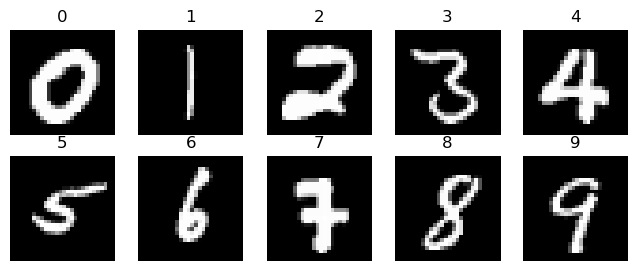

In [3]:
# One fig with 2*5 subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(8,3))
for i, ax in enumerate(axes.flat):
    # Find an image in the dataset with the right label
    img = next(img for img, label in data_train if label == i)
    # Plot image
    ax.imshow(img, cmap='gray')
    # Add title
    ax.set_title(i)
    # Remove ticks
    ax.axis('off')

plt.show()

#### Count the number of elements for each class

**TODO**

1. Count the number of elements for each class in each of the 3 datasets. 
2. Does the dataset seem balanced?

**Hints**

You can adapt the corresponding code from the 1st tutorial, "1.4 Count how many samples there are for each class"

In [4]:
for data_name, data in zip(['train', 'val', 'test'], [data_train, data_val, data_test]):
    print(" ------- ", data_name, " ------- ")
    print(Counter([label for _, label in data]))
    

 -------  train  ------- 
Counter({1: 6075, 7: 5644, 3: 5522, 2: 5365, 9: 5358, 0: 5345, 6: 5310, 8: 5249, 4: 5243, 5: 4889})
 -------  val  ------- 
Counter({1: 667, 7: 621, 3: 609, 6: 608, 8: 602, 4: 599, 2: 593, 9: 591, 0: 578, 5: 532})
 -------  test  ------- 
Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


## 2. Preprocessing

The preprocessing step typically comes *after* loading the data, but as we saw in the tutorials, the preprocessor can be passed as a parameter of the loading function in Pytorch. 

#### TODO

1. Compute the mean and the standard deviation of the training dataset. Note that contrary to the cifar dataset, the MNIST dataset contains only black and white images, so there is only one channel left. The mean and standard deviation should then be a scalar and not a tensor of 3 elements.
1. Re-load your 3 datasets, now including a preprocessor that:
    1. Crop the images from 28x28 to 24x24 (see [transforms.CenterCrop](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.CenterCrop))
    2. Convert images to tensors (see [transforms.ToTensorp](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor))
    3. Normalize the dataset using the computed mean and standard deviation (see [transforms.Normalize](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Normalize))
    
**Hints**
- You can adapt the corresponding code from the 1st tutorial. "2. Transforms"
- Use [transforms.Compose](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Compose) to define your preprocessor as a combination of your transforms

In [5]:
imgs = torch.stack([transforms.functional.to_tensor(img) for img, _ in data_train])
print(imgs.shape)
# Instanciate a normalize transform 
# using the mean and standard deviation of our dataset
#
# The shape is '(54000, 1, 28, 28)' and we want the mean/std
# of the only RBG channel so of the entire tensor
mean = imgs.mean()
std = imgs.std()
normalizer = transforms.Normalize(mean, std)
print("Mean: ", mean, "std: ", std)

torch.Size([54000, 1, 28, 28])
Mean:  tensor(0.1306) std:  tensor(0.3080)


In [6]:
mnist_preprocessor = transforms.Compose([
            transforms.CenterCrop(24),
            transforms.ToTensor(),
            normalizer,
        ])
data_train, data_val, data_test = load_MNIST(preprocessor=mnist_preprocessor)

Size of the train dataset:         54000
Size of the validation dataset:    6000
Size of the test dataset:          10000


## 3. Building different models

**TODO**

Define 2 (or 3) neural networks by writing classes inheriting the ``nn.Module`` class.

**Hints**

- See the 3rd tutorial, "2.2 Using the functional API"
- 2-3 layers are enough, otherwise the training will take too long if you don't have a gpu.
- Use only linear layers [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear), (and potentially non-trainable layers such as [F.max_pool2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.max_pool2d.html?highlight=max_pool#torch.nn.functional.max_pool2d) or [torch.flatten](https://pytorch.org/docs/stable/generated/torch.flatten.html#torch.flatten)) we will study the other types of layers later on this semester.
- Remember that we don't need a softmax function in the output layer if we use [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=crossentro#torch.nn.CrossEntropyLoss) as the loss function


In [7]:
class MyNet01(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(24*24, 64)
        self.fc2 = nn.Linear(64, 10)
    def forward(self, x):
        out = torch.flatten(x, 1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

class MyNet02(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(24//2 * 24//2, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        out = torch.flatten(F.max_pool2d(x, 2), 1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out


## 4. Training models

**TODO**  
Write a function ``train`` that 
- Trains the model for ``n`` epochs (complete passes through the training dataset)
- Computes and stores the training loss and the validation loss for each epoch
- Returns the list of training and validation losses

**Hints**
- You can find how to train and compute the training loss in the the ``train`` function in the tutorials. However, you need to modify this function in order to return the validation loss as well.
- Use [mode.train()](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.train) and [model.eval()](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval) correctly (see ``train`` and ``compute_accuracy`` in the tutorials)
- Use "with [torch.no_grad()](https://pytorch.org/docs/stable/generated/torch.no_grad.html#torch.no_grad):" correctly (see ``compute_accuracy`` in the tutorials)
- Don't backpropagate the loss when computing validation loss (see ``compute_accuracy`` in the tutorials)
- Don't update weights when computing validation loss (see ``compute_accuracy`` in the tutorials)
- Here, we want the validation loss, not the accuracy on the validation dataset.
- Both ``train`` and ``compute_accuracy`` are written at the beginning of the 3rd tutorial, with detailed explanation in the 2nd tutorial.

In [8]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, device=None):
    if device is None:
        device = (
            torch.device('cuda') if torch.cuda.is_available()
            else torch.device('cpu'))
    print(f"Training on device {device}.")
    
    #model.train() moved inside loop!
    optimizer.zero_grad(set_to_none=True)
    
    n_batch_train = len(train_loader)
    n_batch_val = len(val_loader)
    
    losses_train = []
    losses_val = []
    
    for epoch in range(1, n_epochs + 1):
        
        # Train model and compute training loss
        model.train()
        loss_train = 0.0
        for imgs, labels in train_loader:

            imgs = imgs.to(device=device) 
            labels = labels.to(device=device)

            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()
            
        losses_train.append(loss_train / n_batch_train)
            
        # Compute validation loss
        model.eval()
        # Prevent Pytorch from computing and keeping track of gradients
        with torch.no_grad():
            loss_val = 0.0
            for imgs, labels in val_loader:
                
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)

                outputs = model(imgs)
                loss = loss_fn(outputs, labels)

                # The backpropagation and update steps have disappeared!

                loss_val += loss.item()
                
        losses_val.append(loss_val / n_batch_val)

        if epoch == 1 or epoch % 1 == 0:
            # We can now print the validation loss in addition to the training one
            print('{}  |  Epoch {}  |  Training loss {:.5f}  |  Validation loss {:.5f}'.format(
                datetime.now().time(), epoch,
                loss_train / n_batch_train, loss_val / n_batch_val))
            
    return (losses_train, losses_val)

**TODO**  

1. Define a train loader and a validation loader. 
2. Train 3 different models, i.e.:
    1. Instanciate a model using your custom Pytorch modules  
    2. Choose an optimizer (and its parameters, e.g the learning rate)  
    3. Choose a loss function  (e.g cross-entropy)
    4. Train your model and store its training and validation loss

**Hints**

- Again, you can find some hints in the tutorials
- 20 epochs or even a bit less are enough if your computer is a bit slow
- If you defined only 2 modules in section 3, you can also play with the learning rate 

In [9]:
device = (
    torch.device('cuda') if torch.cuda.is_available()
    else torch.device('cpu'))

n_epochs = 20
batch_size = 256

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=True)

models = []
model_names = []
losses_train = []
losses_val = []

model = MyNet01().to(device=device) 
optimizer = optim.SGD(model.parameters(), lr=1e-1)
loss_fn = nn.CrossEntropyLoss()

loss_train, loss_val = train(
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader,
    device = device,
)

models.append(model)
model_names.append('MyNet01, lr=0.1')
losses_train.append(loss_train)
losses_val.append(loss_val)


Training on device cpu.
14:29:14.979422  |  Epoch 1  |  Training loss 0.45565  |  Validation loss 0.26748
14:29:26.945379  |  Epoch 2  |  Training loss 0.23881  |  Validation loss 0.20466
14:29:37.745277  |  Epoch 3  |  Training loss 0.18935  |  Validation loss 0.17954
14:29:48.993503  |  Epoch 4  |  Training loss 0.15790  |  Validation loss 0.15032
14:29:59.289656  |  Epoch 5  |  Training loss 0.13556  |  Validation loss 0.13862
14:30:11.419801  |  Epoch 6  |  Training loss 0.11940  |  Validation loss 0.12885
14:30:23.487873  |  Epoch 7  |  Training loss 0.10682  |  Validation loss 0.11938
14:30:34.426093  |  Epoch 8  |  Training loss 0.09676  |  Validation loss 0.11790
14:30:45.510723  |  Epoch 9  |  Training loss 0.08864  |  Validation loss 0.11438
14:30:55.865924  |  Epoch 10  |  Training loss 0.08177  |  Validation loss 0.10551
14:31:06.784833  |  Epoch 11  |  Training loss 0.07546  |  Validation loss 0.10298
14:31:17.901560  |  Epoch 12  |  Training loss 0.07010  |  Validation lo

In [10]:
model = MyNet02().to(device=device) 
optimizer = optim.SGD(model.parameters(), lr=1e-1, weight_decay=0.01)
loss_fn = nn.CrossEntropyLoss()

loss_train, loss_val = train(
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader,
    device = device,
)

models.append(model)
model_names.append('MyNet02, lr=0.1')
losses_train.append(loss_train)
losses_val.append(loss_val)

Training on device cpu.
14:33:06.074267  |  Epoch 1  |  Training loss 0.56117  |  Validation loss 0.34841
14:33:17.103609  |  Epoch 2  |  Training loss 0.32352  |  Validation loss 0.29517
14:33:27.864265  |  Epoch 3  |  Training loss 0.28972  |  Validation loss 0.27856
14:33:39.052454  |  Epoch 4  |  Training loss 0.26985  |  Validation loss 0.25280
14:33:51.070010  |  Epoch 5  |  Training loss 0.25603  |  Validation loss 0.25331
14:34:05.014420  |  Epoch 6  |  Training loss 0.24586  |  Validation loss 0.23893
14:34:16.767499  |  Epoch 7  |  Training loss 0.23793  |  Validation loss 0.22958
14:34:27.986762  |  Epoch 8  |  Training loss 0.23108  |  Validation loss 0.22681
14:34:42.921686  |  Epoch 9  |  Training loss 0.22612  |  Validation loss 0.22149
14:34:54.298993  |  Epoch 10  |  Training loss 0.22146  |  Validation loss 0.21887
14:35:07.711699  |  Epoch 11  |  Training loss 0.21886  |  Validation loss 0.21434
14:35:19.780553  |  Epoch 12  |  Training loss 0.21529  |  Validation lo

In [11]:
model = MyNet02().to(device=device) 
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

loss_train, loss_val = train(
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader,
    device = device,
)

models.append(model)
model_names.append('MyNet02, lr=0.01')
losses_train.append(loss_train)
losses_val.append(loss_val)

Training on device cpu.
14:36:57.929740  |  Epoch 1  |  Training loss 1.52113  |  Validation loss 0.89669
14:37:10.033516  |  Epoch 2  |  Training loss 0.70140  |  Validation loss 0.56204
14:37:22.400584  |  Epoch 3  |  Training loss 0.51371  |  Validation loss 0.45544
14:37:34.345077  |  Epoch 4  |  Training loss 0.44236  |  Validation loss 0.40726
14:37:45.929110  |  Epoch 5  |  Training loss 0.40347  |  Validation loss 0.37985
14:37:57.425613  |  Epoch 6  |  Training loss 0.37821  |  Validation loss 0.35531
14:38:10.424974  |  Epoch 7  |  Training loss 0.35970  |  Validation loss 0.34183
14:38:23.129599  |  Epoch 8  |  Training loss 0.34506  |  Validation loss 0.33173
14:38:35.079395  |  Epoch 9  |  Training loss 0.33305  |  Validation loss 0.32224
14:38:46.489431  |  Epoch 10  |  Training loss 0.32280  |  Validation loss 0.30743
14:38:57.642407  |  Epoch 11  |  Training loss 0.31359  |  Validation loss 0.30053
14:39:08.851284  |  Epoch 12  |  Training loss 0.30536  |  Validation lo

#### Ploting the evolution of the training loss and the validation loss during the training

**TODO**

For each of your 3 models, plot the training loss and the validation loss. You can adapt the code in the cell below to plot your curves.

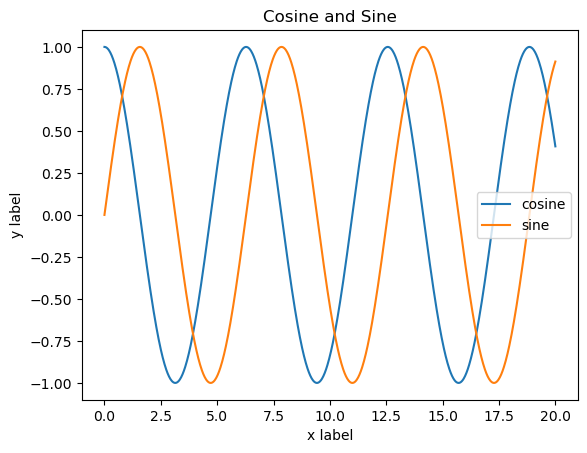

In [12]:
xvalues = np.linspace(0, 20, 1000)
yvalues01 = np.cos(xvalues)
yvalues02 = np.sin(xvalues)

fig, ax = plt.subplots()

# Plot cosine and specify its legend label
ax.plot(xvalues, yvalues01, label='cosine')
# Plot sine and specify its legend label
ax.plot(xvalues, yvalues02, label='sine')
ax.set_title('Cosine and Sine')
ax.set_xlabel('x label')
ax.set_ylabel('y label')
# Show legend
ax.legend()

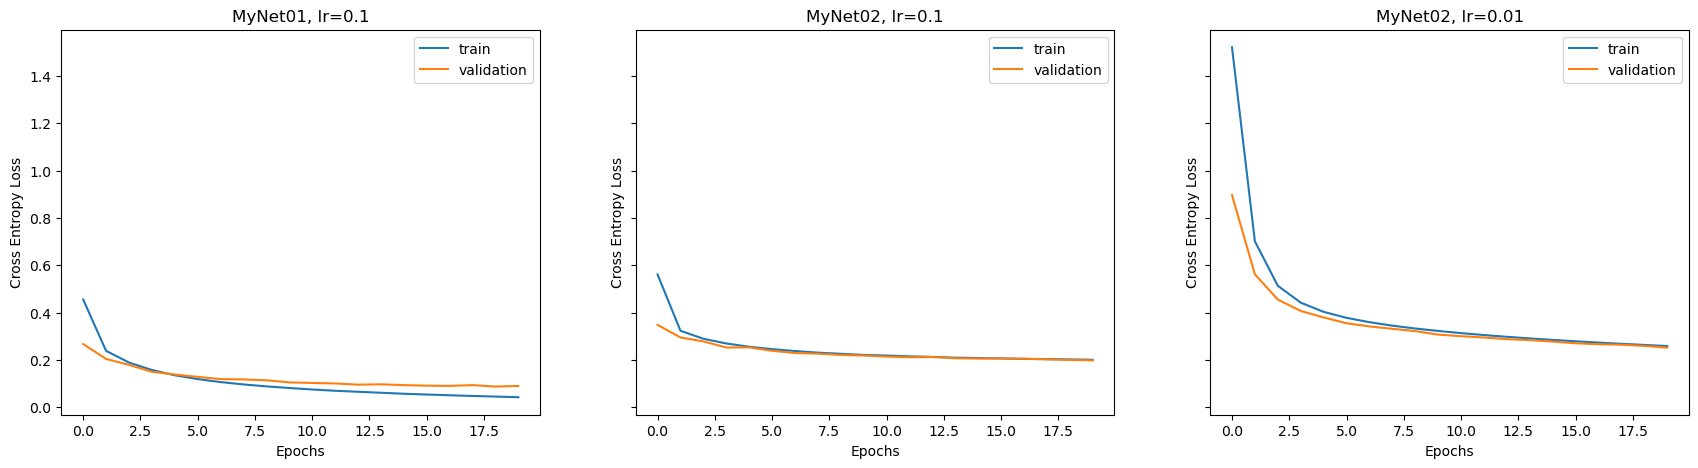

In [13]:
n_model = len(models)

fig, axes = plt.subplots(1, n_model, figsize=(7*n_model, 5), sharey=True)

for l_train, l_val, name, ax in zip(losses_train, losses_val, model_names, axes.flat):

    ax.plot(l_train, label='train')
    ax.plot(l_val, label='validation')
    ax.set_title(name)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Cross Entropy Loss')
    ax.legend()

plt.show()

## 5. Model selection

1. Write a function ``compute_accuracy`` that computes the accuracy of a given model on a given dataset. You can find all you need in the tutorials.
2. Select your best model, that is to say:
    1. For each model, compute the accuracy on the validation dataset
    2. Choose the model with the highest accuracy
3. Print the training and the validation accuracies of your selected model

In [14]:
def compute_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    acc =  correct / total
    print("Accuracy: {:.4f}".format(acc))
    return acc

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=False)

accuracies = []

for model in models:
    accuracies.append(compute_accuracy(model, val_loader))
    
i_best_model = np.argmax(accuracies)
best_model = models[i_best_model]
print("\nThe best model is ", model_names[i_best_model])


print("Training accuracy of the best model: ")
compute_accuracy(best_model, train_loader)
print("Validation accuracy of the best model: ")
compute_accuracy(best_model, val_loader)

Accuracy: 0.9732
Accuracy: 0.9465
Accuracy: 0.9240

The best model is  MyNet01, lr=0.1
Training accuracy of the best model: 
Accuracy: 0.9899
Validation accuracy of the best model: 
Accuracy: 0.9732


0.9731666666666666

## 6. Model evaluation

**TODO**

1. Evaluate your selected model, that is to say, compute and print the accuracy of your selected model on the test dataset

In [15]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, shuffle=False)

print("Test accuracy of the best model: ")
compute_accuracy(best_model, test_loader)

Test accuracy of the best model: 
Accuracy: 0.9732


0.9732